In [1]:
!pip install gower
from collections import Counter

ARAUCANAXAI FUNCTIONS

In [2]:
SEED: int = 42
NFOLD: int = 5
NEIGHBOURHOOD_SIZE: float = .01
OVERSAMPLING: str = None
OVERSAMPLING_SIZE: int = 100
MAX_DEPTH: int = None
MIN_SAMPLES_LEAF: int = 1
SPLIT: float = .75


from warnings import warn
from pandas import DataFrame
from math import ceil
import numpy as np
from sklearn import tree
from sklearn import datasets
from gower import gower_matrix
from imblearn.over_sampling import SMOTENC, SMOTEN


def load_breast_cancer(train_split=SPLIT, cat=True):
    """
    Load toy dataset crafted from the breast cancer wisconsin dataset.

    :param train_split: proportion of training data
    :param cat: boolean flag to specify if the dataset should contain also categorical features

    :returns:
        - X_train: training set
        - y_train: training target class
        - X_test: test set
        - y_test: test target class
        - feature_names: feature names
        - target_names: class names
    """
    cancer = datasets.load_breast_cancer()
    cancer.data = cancer.data[:, 0:10]
    cancer.feature_names = cancer.feature_names[0:10]
    # if cat, convert the first 5 features from continuous to discrete values
    if cat:
        for i in range(0, 5):
            cancer.data[:, i] = cancer.data[:, i] > np.mean(cancer.data[:, i])
            cancer.data[:, i] = cancer.data[:, i].astype(np.int32)
        cancer.feature_names[0:5] = ['radius', 'texture', 'perimeter', 'area', 'smoothness']
    ind = round(len(cancer.data) * train_split)
    return {
        "X_train": cancer.data[0:ind],
        "y_train": cancer.target[0:ind],
        "X_test": cancer.data[ind:len(cancer.data)],
        "y_test": cancer.target[ind:len(cancer.data)],
        "feature_names": cancer.feature_names,
        "target_names": cancer.target_names
    }


def __find_nearest_class(target: np.ndarray, data: np.ndarray, data_class: np.ndarray, val_class: 0, min_size=1,
                         cat_list: list = None):
    """
    Finds the closest instance that satisfies the condition of having at least min_size instances of a class different than val_class.

    :param target: target example
    :param data: data where to find the nearest neighbours
    :param data_class: data labels
    :param val_class: value of the majority label
    :param min_size: desired minimum number of neighbours with a label that is not val_class
    :param cat_list: list of booleans to specify which variables are categorical

    :return: index of the closest instance that satisfies the condition
    """
    d_gow = gower_matrix(target, data, cat_features=cat_list)
    d2index = dict(zip(d_gow[0].tolist(), list(range(data.shape[0]))))
    my_index = [d2index[i] for i in np.sort(d_gow)[0].tolist()]
    local_training_set_y = data_class[my_index]  # sorted y
    # first index that satisfies the condition of having at least min_size instances
    # where y!=y_target
    min_index = np.where(local_training_set_y != val_class)[0][min_size - 1]
    return min_index


def __find_neighbours(target: np.ndarray, data: np.ndarray, cat_list: list = None,
                      n=NEIGHBOURHOOD_SIZE):
    """
    Finds the n nearest neighbours to the target example according to the Gower distance.

    :param target: target example
    :param data: data where to find the nearest neighbours
    :param cat_list: list of booleans to specify which variables are categorical
    :param n: number of neighbours to find

    :return: nearest n neighbours
    """
    if target.ndim != data.ndim: raise TypeError("target and data must have the same number of dimensions!")
    # Gower distance matrix
    d_gow = gower_matrix(target, data, cat_features=cat_list)
    # Let's select the first k neighbours
    d2index = dict(zip(d_gow[0].tolist(), list(range(data.shape[0]))))
    # Check on n: if less than 1, it has to be considered as % of training set
    if n < 1:
        n = int(ceil(data.shape[0] * n))
    my_index = [d2index[i] for i in np.sort(d_gow)[0][0:n].tolist()]
    # nk nearest neighbours in the training set according to gower distance
    local_training_set = data[my_index, :]
    return local_training_set


def __random_oversample(x_local, x_instance, cat_list: list = None, size: int = 1, uniform: bool = True,
                        seed: int = SEED):
    """
    Local data augmentation by randomly generate new instances. Non-uniform random oversampling will use sample statistics to generate the new instances.

    :param x_local: local set of examples to use for oversampling
    :param x_instance: target example
    :param cat_list: list of booleans to specify which variables are categorical
    :param size: number of new instances to generate
    :param uniform: specify if the new instances must be drawn from uniform distribution or not
    :param seed: specify random state

    :return: oversampled local data
    """
    x = np.concatenate((x_local, x_instance))
    o = np.zeros((size, x.shape[1]))
    np.random.seed(seed)
    for i in range(x.shape[1]):
        column = x[:, i]
        if cat_list is not None and cat_list[i]:
            if uniform:
                o[:, i] = np.random.randint(low=int(np.min(column)), high=int(np.max(column)) + 1, size=size)
            else:
                vals, counts = np.unique(column, return_counts=True)
                o[:, i] = np.random.choice(a=np.unique(column), size=size, p=counts / sum(counts))
        else:
            if uniform:
                o[:, i] = np.random.uniform(low=np.min(column), high=np.max(column), size=size)
            else:  # if not uniform, we can generate from normal distribution
                mu, sigma = np.mean(column), np.std(column)  # mean and standard deviation
                o[:, i] = np.random.normal(mu, sigma, size=size)
    return np.concatenate((x, o))


def __oversample(x_local, x_instance,
                 y_local_pred, y_instance_pred,
                 cat_list: list = None, oversampling: str = None,
                 oversampling_size: int = 100, seed: int = SEED):
    """
    Local data augmentation with SMOTE (Synthetic Minority Oversampling TEchnique).

    :param x_local: local set of examples to use for oversampling
    :param x_instance: target example
    :param y_local_pred: predicted class for the local set of examples
    :param y_instance_pred: predicted class for the target instance
    :param cat_list: list of booleans to specify which variables are categorical
    :param oversampling: type of oversampling. Possible values: smote, uniform, non-uniform, none. Default: None
    :param oversampling_size: number of new instances to be generated. Not used when oversampling_type=smote
    :param seed: specify random state

    :return: oversampled local data
    """
    if oversampling == "smote":
        if cat_list is None:
            smote = SMOTEN(random_state=seed, sampling_strategy='all')
        else:
            smote = SMOTENC(categorical_features=np.where(cat_list)[0].tolist(), random_state=seed,
                            sampling_strategy='all')

        return smote.fit_resample(np.concatenate((x_local, x_instance)),
                                  np.append(y_local_pred, y_instance_pred))[0]  # return X only, we don't need y
    else:
        return __random_oversample(x_local=x_local, x_instance=x_instance,
                                   cat_list=cat_list, size=oversampling_size, uniform=(oversampling == "uniform"),
                                   seed=seed)


def __create_tree(X, y, X_features, max_depth=MAX_DEPTH,
                  min_samples_leaf=MIN_SAMPLES_LEAF):
    """
    Grow a classification tree without pruning.
    Note: why a fixed seed? According to this issue (github.com/scikit-learn/scikit-learn/issues/2386), by default the sklearn implementation for decision tree classifiers is NOT deterministic, even if max_features=n_features and splitter=best, because the implementation will still sample them at random from the list of features even though this means all features will be sampled. Thus, the order in which the features are considered is pseudo-random and a deterministic behaviour between different runs can be achieved only if the random state is fixed a priori.


    :param X: training set
    :param y: class to be predicted
    :param X_features: feature names
    :param max_depth: the maximum depth of the tree. If None, no depth-based pruning is applied.
    :param min_samples_leaf: the minimum number of samples required to be at a leaf node. If int, the value is the minimum number. If float, then ceil(min_samples_leaf*n_samples) is the minimum number of samples for each node.
    :param seed: specify random state

    :return: classification tree
    """
    clf_tree_0 = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
    clf_tree_0.fit(DataFrame(X, columns=X_features), y)
    return clf_tree_0


def __sort_unique_by_freq(array: np.array):
    """
    Return unique values of an array, sorted by descending frequency
    """
    unique_elements, frequency = np.unique(array, return_counts=True)
    sorted_indexes = np.argsort(frequency)[::-1]
    return unique_elements[sorted_indexes]


def __get_suggested_min_n_smote(x_target, x_train, y_local, y_train, cat_list):
    """
    Return the minimum neighborhood size for smote
    """
    k = SMOTEN().k_neighbors + 1  # default k used in SMOTE (+1 to include the target instance)
    y_most_freq = __sort_unique_by_freq(y_local)[0]
    return __find_nearest_class(x_target, x_train, y_train, y_most_freq, k, cat_list) + 1


def run(x_target, y_pred_target, x_train, feature_names, cat_list, predict_fun,
        neighbourhood_size=NEIGHBOURHOOD_SIZE, oversampling=OVERSAMPLING,
        oversampling_size=OVERSAMPLING_SIZE,
        max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLES_LEAF, seed=SEED):
    """
    Run the AraucanaXAI algorithm and plot the calssification tree.

    :param x_target:
    :param y_pred_target:
    :param x_train:
    :param feature_names:
    :param cat_list: list of booleans to specify which variables are categorical
    :param predict_fun: function used to predict the outcomes, i.e. the model we want to explain. Function must have one input only: the data.
    :param neighbourhood_size: specify the number of neighbours to consider
    :param oversampling: type of oversampling. Possible values: smote, uniform, non-uniform, none. Default: None
    :param oversampling_size: number of new instances to be generated. Not used when oversampling_type=smote. Default: 100
    :param max_depth: the maximum depth of the tree. If None, no depth-based pruning is applied. Default: None
    :param min_samples_leaf: the minimum number of samples required to be at a leaf node. If int, the value is the minimum number. If float, then ceil(min_samples_leaf*n_samples) is the minimum number of samples for each node. Default: 1
    :param seed: specify random state

    :returns:
        - tree: classification tree
        - data: resampled data
        - acc: accuracy on resampled data
    """

    # 1) FIND NEIGHBOURS
    local_train = __find_neighbours(target=x_target,
                                    data=x_train,
                                    cat_list=cat_list,
                                    n=neighbourhood_size)
    y_local_train = predict_fun(local_train)
    suggested_min_n = __get_suggested_min_n_smote(x_target=x_target,
                                                  x_train=x_train,
                                                  y_local=y_local_train,
                                                  y_train=predict_fun(x_train),
                                                  cat_list=cat_list)

    # 2) OVERSAMPLING
    os_check_passed = False
    if oversampling is not None:
        # if oversampling == "smote" and (neighbourhood_size < suggested_min_n):
        #     warn(
        #         "Cannot run SMOTE oversampling due to insufficient neighborhood size. Required minimum neighborhood size: %d . Oversampling skipped." % suggested_min_n)
        if oversampling in ["smote", "uniform", "non-uniform"]:
            os_check_passed = True
        else:
            warn("Unrecognized oversampling type. Supported methods: smote, uniform, non-uniform.")

    if os_check_passed:
        X_res = __oversample(x_local=local_train,
                             x_instance=x_target,
                             y_local_pred=y_local_train,
                             y_instance_pred=y_pred_target,
                             cat_list=cat_list,
                             oversampling=oversampling,
                             oversampling_size=oversampling_size,
                             seed=seed)
        y_res = predict_fun(X_res)
    else:
        X_res = np.concatenate((local_train, x_target))
        y_res = np.append(y_local_train, y_pred_target)

    # 3) CREATE TREE
    xai_c = __create_tree(X_res, y_res, feature_names,
                          max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    return {'tree': xai_c,
            'data': [X_res, y_res],
            'acc': xai_c.score(X_res, y_res)}

* Generation of a clinical dataset based on the Revised International Prognostic Scoring System (IPSS-R) for Myelodysplastic Syndromes Risk Assessment Calculator *

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

random.seed(84)

In [4]:
#Rules for associating a prognostic score to the values of the clinical features

def rule_hgb(hgb):
  if hgb < 10:
    if hgb < 8:
      val = 1.5
    else:
      val = 1
  else:
    val = 0
  return val

def rule_anc(anc):
  if anc < 0.8:
    val = 0.5
  else:
    val = 0
  return val

def rule_plat(plat):
  if plat < 100:
    if plat < 50:
      val = 1
    else:
      val = 0.5
  else:
    val = 0
  return val

def rule_bmb(bmb):
  if bmb <= 10:
    if bmb <= 5:
      if bmb <= 2:
        val = 0
      else:
        val = 1
    else:
      val = 2
  else:
    val = 3
  return val

def rule_cyto(cyto):
  if cyto == 4:
    val = 4
  elif cyto == 3:
    val = 3
  elif cyto == 2:
    val = 2
  elif cyto == 1:
    val = 1
  elif cyto == 0:
    val = 0
  return val

rules = [rule_hgb, rule_anc, rule_plat, rule_bmb, rule_cyto]

In [5]:
#Function for generating the IID samples

def generate_dataset(n_samples, rules):
  dataset = pd.DataFrame(columns=['Hgb','ANC','Platelets','BMB%','Cytogenetics','Risk'])
  for i in range(n_samples):
    score = 0
    hgb = random.randrange(4,21)
    anc = random.randrange(0,16)
    plat = random.randrange(0,2001)
    bmb = random.randrange(0,31)
    cyto = random.randrange(0,5)
    data = [float(hgb), float(anc), float(plat), float(bmb), float(cyto)]

    for i in range(len(rules)):
      score = score + rules[i](data[i])

    if score <= 4.5:
      risk = 0
    else:
      risk = 1

    dataset.loc[len(dataset.index)] = [hgb, anc, plat, bmb, cyto, risk]

  return dataset

In [6]:
#Function with a chance of 50% to generate OOD samples
def generate_ood_dataset(n_samples, rules):
  dataset = pd.DataFrame(columns=['Hgb','ANC','Platelets','BMB%','Cytogenetics','Risk','ood_col','out'])
  for i in range(n_samples):
    ix = random.randrange(0,4)
    out = random.random() <= 0.5
    score = 0
    if ix == 0:
      if out:
        hgb = random.randrange(22,42)
      else:
        hgb = random.randrange(4,21)
    else:
      hgb = random.randrange(4,21)
    if ix == 1:
      if out:
        anc = random.randrange(17,32)
      else:
        anc = random.randrange(0,16)
    else:
      anc = random.randrange(0,16)
    if ix == 2:
      if out:
        plat = random.randrange(2002,4002)
      else:
        plat = random.randrange(0,2001)
    else:
      plat = random.randrange(0,2001)
    if ix == 3:
      if out:
        bmb = random.randrange(32,62)
      else:
        bmb = random.randrange(0,31)
    else:
      bmb = random.randrange(0,31)
    cyto = random.randrange(0,5)
    data = [float(hgb), float(anc), float(plat), float(bmb), float(cyto)]

    for i in range(len(rules)):
      score = score + rules[i](data[i])

    if score <= 4.5:
      risk = 0
    else:
      risk = 1

    dataset.loc[len(dataset.index)] = [hgb, anc, plat, bmb, cyto, risk, ix, out]

  return dataset

In [7]:
# IN-Distribution Dataset
dataset = generate_dataset(1000, rules)
X = dataset.copy()
y = X.pop('Risk')
# OOD Dataset
ood = generate_ood_dataset(700, rules)
y_ood = ood.pop('Risk')
ood_col = ood.pop('ood_col')
is_out = ood.pop('out')

In [8]:
#Class distribution of the IID and the OOD datasets
print("IID:",Counter(y))
print("\nOOD:",Counter(y_ood))

IID: Counter({1: 517, 0: 483})

OOD: Counter({1: 396, 0: 304})


In [9]:
#Train-Val-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42)
X_train_np = np.asarray(X_train).astype(float)
X_val_np = np.asarray(X_val).astype(float)
X_test_np = np.asarray(X_test).astype(float)
y_train_np = np.asarray(y_train)
y_val_np = np.asarray(y_val)
y_test_np = np.asarray(y_test)

ood_np = np.asarray(ood).astype(float)
y_ood_np = np.asarray(y_ood)

In [10]:
#PREPROCESSING: Normalization between -1 and 1

def normalize_range(X, xtrainmin, xtrainmax):
  X_norm = []
  for i in range(X.shape[0]):
    vec_temp = []
    for j in range(X.shape[1]):
      if xtrainmin[j] == xtrainmax[j]:
        norm_x = X[i,j]
      else:
        norm_x = 2*(X[i,j]-xtrainmin[j])/(xtrainmax[j]-xtrainmin[j])-1
      vec_temp.append(norm_x)
    X_norm.append(vec_temp)
  return np.asarray(X_norm)

In [11]:
#PREPROCESSING: Normalization between -1 and 1

X_train_np_min = []
X_train_np_max = []
X_train_np_mean = []
X_train_np_std = []

for i in range(len(X_train_np[0,:])):
  vec = X_train_np[~np.isnan(X_train_np[:,i]),i]
  X_train_np_min.append(min(vec))
  X_train_np_max.append(max(vec))

X_train_np = normalize_range(X_train_np, X_train_np_min, X_train_np_max)
X_val_np = normalize_range(X_val_np, X_train_np_min, X_train_np_max)
X_test_np = normalize_range(X_test_np, X_train_np_min, X_train_np_max)

ood_np = normalize_range(ood_np, X_train_np_min, X_train_np_max)

In [12]:
#Model Training

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(max_depth = 10)
tree_clf.fit(X_train_np, y_train_np)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100), max_iter=10000, random_state=42)
mlp_clf.fit(X_train_np, y_train_np)
svm_clf = SVC(kernel='rbf', random_state=65)
svm_clf.fit(X_train_np, y_train_np)
lr_clf = LogisticRegression(random_state=84, solver='liblinear', penalty='l1', max_iter=500)
lr_clf.fit(X_train_np, y_train_np)
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_np, y_train_np)

print("Accuracy Test set (IID)\n")
print("D3: ",accuracy_score(y_test_np, tree_clf.predict(X_test_np)))
print("RF: ",accuracy_score(y_test_np, rf_clf.predict(X_test_np)))
print("LR: ",accuracy_score(y_test_np, lr_clf.predict(X_test_np)))
print("SVM:",accuracy_score(y_test_np, svm_clf.predict(X_test_np)))
print("MLP:",accuracy_score(y_test_np, mlp_clf.predict(X_test_np)))

print("\nAccuracy OOD set\n")
print("D3: ",accuracy_score(y_ood_np, tree_clf.predict(ood_np)))
print("RF: ",accuracy_score(y_ood_np, rf_clf.predict(ood_np)))
print("LR: ",accuracy_score(y_ood_np, lr_clf.predict(ood_np)))
print("SVM:",accuracy_score(y_ood_np, svm_clf.predict(ood_np)))
print("MLP:",accuracy_score(y_ood_np, mlp_clf.predict(ood_np)))

clf = svm_clf

Accuracy Test set (IID)

D3:  0.988
RF:  0.968
LR:  0.892
SVM: 0.952
MLP: 0.988

Accuracy OOD set

D3:  0.9771428571428571
RF:  0.9728571428571429
LR:  0.8514285714285714
SVM: 0.8257142857142857
MLP: 0.9685714285714285


RELIABILITY ASSESSMENT

In [13]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [14]:
from ReliabilityPackage.ReliabilityFunctions import *

EPOCH 1
EPOCH 2
.
.
EPOCH 1999
EPOCH 2000


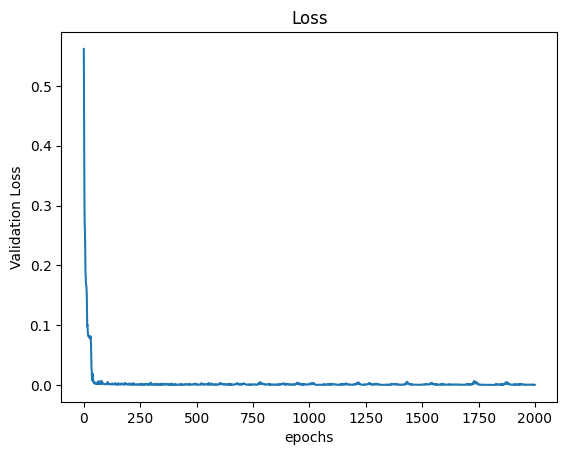

In [15]:
#Train an autoencoder on the IID training set

ae = create_and_train_autoencoder(X_train_np, X_val_np, batchsize=100, epochs=2000, optimizer_params = {'lr': 0.01, 'weight_decay': 1e-8})

In [16]:
#Generate the synthetic points and their associated values of accuracy computed with the classifier

syn_pts, acc_syn_pts = generate_synthetic_points("classification", clf.predict, X_train_np, y_train_np, method="GN", k = 5)

In [17]:
#Define a MSE threshold and an Accuracy threshold

mse_thresh = perc_mse_threshold(ae, X_val_np, perc=98)
acc_thresh = 0.80

In [18]:
#Create an instance of the reliability_detector, which can be used to finally assess the reliability of predictions

RD = create_reliability_detector("classification", ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")

In [19]:
#Compute the reliability of the Validation-Test IID sets, and of the OOD set

test_reliability= compute_dataset_reliability(RD, X_test_np, mode='density')
reliable_test = X_test_np[np.where(test_reliability == 1)]
y_reliable_test = y_test_np[np.where(test_reliability == 1)]
ypred_reliable_test = clf.predict(reliable_test)
unreliable_test = X_test_np[np.where(test_reliability == 0)]
y_unreliable_test = y_test_np[np.where(test_reliability == 0)]
ypred_unreliable_test = clf.predict(unreliable_test)

val_reliability= compute_dataset_reliability(RD, X_val_np, mode='density')
reliable_val = X_val_np[np.where(val_reliability == 1)]
y_reliable_val = y_val_np[np.where(val_reliability == 1)]
ypred_reliable_val = clf.predict(reliable_val)
unreliable_val = X_val_np[np.where(val_reliability == 0)]
y_unreliable_val = y_val_np[np.where(val_reliability == 0)]
ypred_unreliable_val = clf.predict(unreliable_val)

ood_reliability = compute_dataset_reliability(RD, ood_np, mode = 'density')
reliable_ood = ood_np[np.where(ood_reliability == 1)]
y_reliable_ood = y_ood_np[np.where(ood_reliability == 1)]
ypred_reliable_ood = clf.predict(reliable_ood)
unreliable_ood = ood_np[np.where(ood_reliability == 0)]
y_unreliable_ood = y_ood_np[np.where(ood_reliability == 0)]
ypred_unreliable_ood = clf.predict(unreliable_ood)
is_out_rel = np.asarray(is_out)[np.where(ood_reliability == 1)]
is_out_unrel = np.asarray(is_out)[np.where(ood_reliability == 0)]

In [20]:
print("Test set:")
print("Reliable:", reliable_test.shape[0], "(",reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_test.shape[0], "(",unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")

print("\nVal set:")
print("Reliable:", reliable_val.shape[0], "(",reliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_val.shape[0], "(",unreliable_val.shape[0]/val_reliability.shape[0]*100,"%)")

print("\nOOD set:")
print("Reliable:", reliable_ood.shape[0], "(",reliable_ood.shape[0]/ood_reliability.shape[0]*100,"%)", "How many Reliable instances have OOD features:", Counter(is_out_rel)[True])
print("Unreliable:", unreliable_ood.shape[0], "(",unreliable_ood.shape[0]/ood_reliability.shape[0]*100,"%)", "How many Unreliable instances have OOD features:", Counter(is_out_unrel)[True])


Test set:
Reliable: 244 ( 97.6 %)
Unreliable: 6 ( 2.4 %)

Val set:
Reliable: 184 ( 97.87234042553192 %)
Unreliable: 4 ( 2.127659574468085 %)

OOD set:
Reliable: 345 ( 49.28571428571429 %) How many Reliable instances have OOD features: 11
Unreliable: 355 ( 50.71428571428571 %) How many Unreliable instances have OOD features: 342


In [21]:
#Performances of the classifier on the reliable and unreliable subsets of the test-validation IID sets and on the reliable and unreliable subsets of the OOD set

from sklearn.metrics import balanced_accuracy_score
print("Test set:")
print("test_set", balanced_accuracy_score(y_test_np,clf.predict(X_test_np)))
print("Reliable test_set", balanced_accuracy_score(y_reliable_test,ypred_reliable_test))
print("Unreliable test_set", balanced_accuracy_score(y_unreliable_test,ypred_unreliable_test))
print("\nVal set:")
print("val_set", balanced_accuracy_score(y_val_np,clf.predict(X_val_np)))
print("Reliable val_set", balanced_accuracy_score(y_reliable_val,ypred_reliable_val))
print("Unreliable val_set", balanced_accuracy_score(y_unreliable_val,ypred_unreliable_val))
print("\nOOD set:")
print("ood_set", balanced_accuracy_score(y_ood_np,clf.predict(ood_np)))
print("Reliable ood_set", balanced_accuracy_score(y_reliable_ood,ypred_reliable_ood))
print("Unreliable ood_set", balanced_accuracy_score(y_unreliable_ood,ypred_unreliable_ood))

Test set:
test_set 0.9522039645279081
Reliable test_set 0.951088068763217
Unreliable test_set 1.0

Val set:
val_set 0.9768085842852198
Reliable val_set 0.9758465833232188
Unreliable val_set 1.0

OOD set:
ood_set 0.84443115364168
Reliable ood_set 0.9631756756756757
Unreliable ood_set 0.7417061611374407


In [22]:
#Function for computing a set of perfomance metrics

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef, average_precision_score, brier_score_loss

def compute_metrics(y, ypred):
  scores = []
  scores.append(balanced_accuracy_score(y, ypred))
  scores.append(precision_score(y, ypred))
  scores.append(recall_score(y, ypred))
  scores.append(f1_score(y, ypred))
  scores.append(matthews_corrcoef(y, ypred))
  scores.append(average_precision_score(y, ypred))
  scores.append(brier_score_loss(y, ypred))

  return scores

In [23]:
#Function to plot the metrics' plots
def metrics_plots(y, ypred, rel_y, rel_ypred, unrel_y, unrel_ypred, name):
  fig, ax = plt.subplots(figsize=(19, 7))
  xbarplot = np.arange(7)
  y1barplot = compute_metrics(y, ypred)
  y2barplot = compute_metrics(rel_y, rel_ypred)
  y3barplot = compute_metrics(unrel_y, unrel_ypred)

  bar_width = 0.27

  b1 = ax.bar(xbarplot, y1barplot, width = bar_width, color='steelblue')
  b2 = ax.bar(xbarplot+bar_width, y2barplot, width = bar_width, color='lightgreen')
  b3 = ax.bar(xbarplot+2*(bar_width), y3barplot, width = bar_width, color='salmon')

  ax.set_xticks(xbarplot + 2*(bar_width) / 2)
  ax.set_xticklabels(['Balanced Accuracy','Precision','Recall','f1-score', 'MCC', 'PRC', 'Brier Score'], fontsize=14)
  ax.legend([name,"Reliable "+name, "Unreliable "+name], fontsize=11)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  # Add axis and chart labels.
  ax.set_title('Performance '+name, pad=15, fontsize=18)

  for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = round(bar.get_height(),3)
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = 'black'
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)

  # Set the fontsize for y-axis bar values
  ax.yaxis.set_tick_params(labelsize=10)
  #fig.tight_layout()

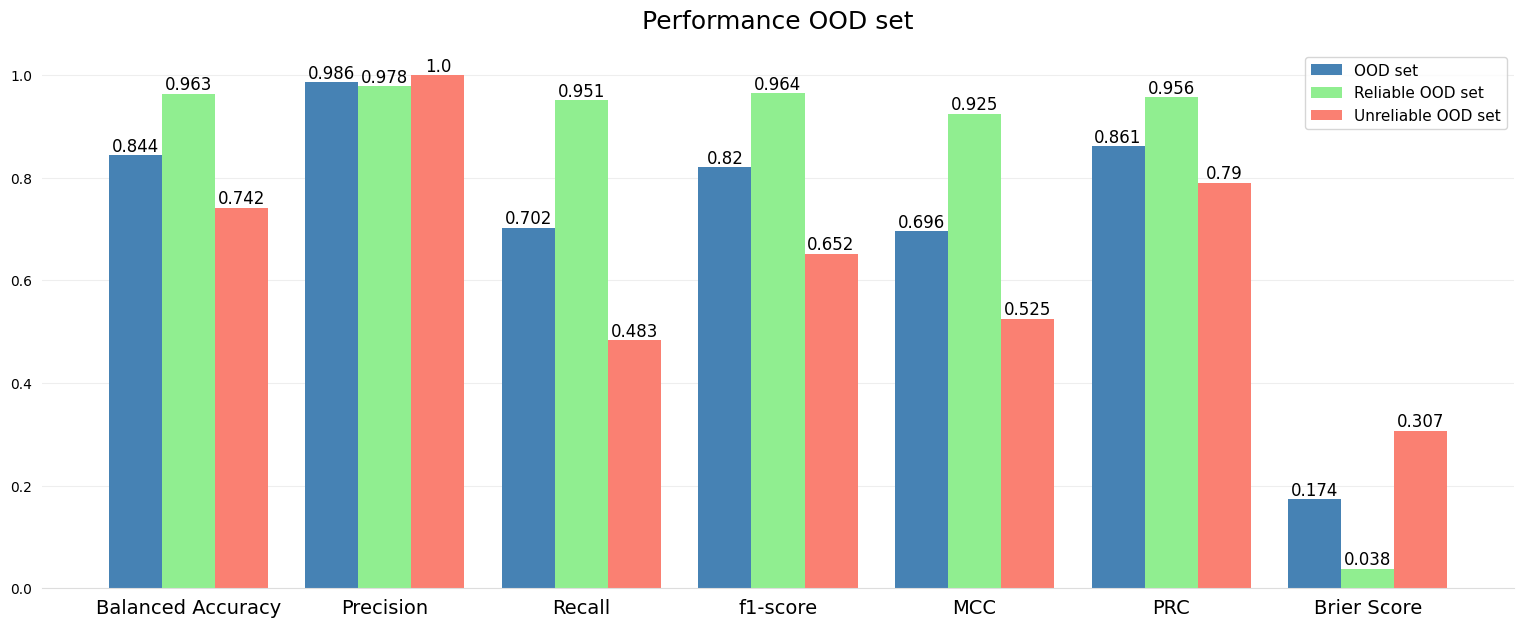

In [24]:
metrics_plots(y_ood_np,clf.predict(ood_np), y_reliable_ood,ypred_reliable_ood, y_unreliable_ood,ypred_unreliable_ood,'OOD set')

In [25]:
#Select 100 samples of the reliable and unreliable subsets of the OOD set, balanced on the true class

np.random.seed(20)
size_bal = 100

high_rel_ood = reliable_ood[np.where(y_reliable_ood == 1)]
y_high_rel_ood = y_reliable_ood[np.where(y_reliable_ood == 1)]
low_rel_ood = reliable_ood[np.where(y_reliable_ood == 0)]
y_low_rel_ood = y_reliable_ood[np.where(y_reliable_ood == 0)]
high_unrel_ood = unreliable_ood[np.where(y_unreliable_ood == 1)]
y_high_unrel_ood = y_unreliable_ood[np.where(y_unreliable_ood == 1)]
low_unrel_ood = unreliable_ood[np.where(y_unreliable_ood == 0)]
y_low_unrel_ood = y_unreliable_ood[np.where(y_unreliable_ood == 0)]

bal_rel_ood = np.concatenate((high_rel_ood[np.random.choice(len(high_rel_ood), size=size_bal, replace=False)], low_rel_ood[np.random.choice(len(low_rel_ood), size=size_bal, replace=False)]))
bal_unrel_ood = np.concatenate((high_unrel_ood[np.random.choice(len(high_unrel_ood), size=size_bal, replace=False)], low_unrel_ood[np.random.choice(len(low_unrel_ood), size=size_bal, replace=False)]))
y_bal_rel_ood = np.concatenate((y_high_rel_ood[0:size_bal], y_low_rel_ood[0:size_bal]))
y_bal_unrel_ood = np.concatenate((y_high_unrel_ood[0:size_bal], y_low_unrel_ood[0:size_bal]))


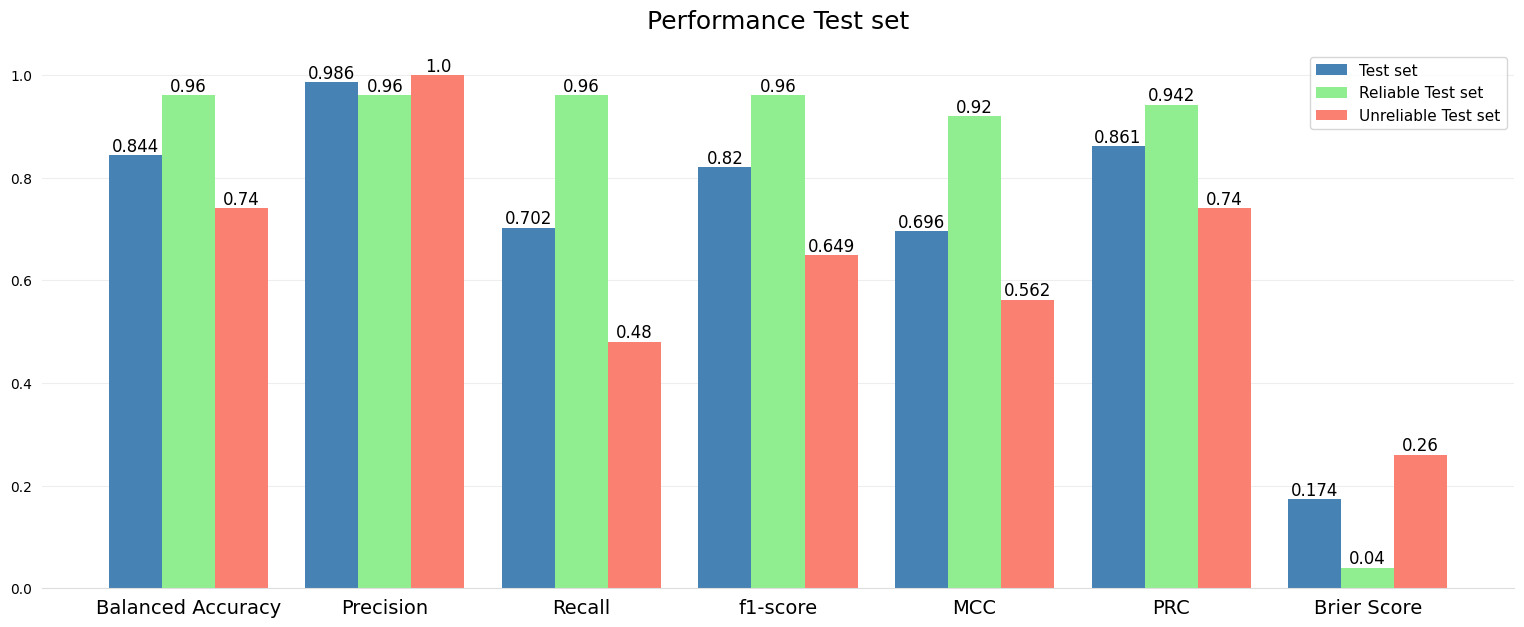

In [26]:
metrics_plots(y_ood_np,clf.predict(ood_np), y_bal_rel_ood,clf.predict(bal_rel_ood), y_bal_unrel_ood,clf.predict(bal_unrel_ood),'Test set')

ARAUCANAXAI APPLICATION

In [27]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names")

In [28]:
#Tested values of AraucanaXAI hyperparameters

n_size = [0.05, 0.07, 0.10, 0.12, 0.15, 0.17, 0.20, 0.22, 0.25, 0.27, 0.30, 0.32, 0.35, 0.37, 0.40, 0.42, 0.45, 0.47, 0.50, 0.52]
o_size = [30, 50, 70, 100, 130, 150, 170, 200, 230, 250, 270, 300, 330, 350, 370, 400, 420, 450, 470, 500]
depth_max = [2]

param_grid = []
for z in range(len(depth_max)):
  for i in range(len(n_size)):
    for j in range(len(o_size)):
      param_grid.append([depth_max[z], n_size[i], o_size[j]])

In [29]:
cat_data = True
is_cat = None
if cat_data:
    # specify which features are categorical
    cat = "Cytogenetics"
    is_cat = [x in cat for x in X_train.columns]

In [30]:
#Compute fidelity of the balanced reliable and unreliable subsets with each combination of AraucanaXAI hyperparameters, based on its provided explanations

fidelity_rel_paramcomb_nos = []
fidelity_rel_paramcomb_os = []
fidelity_unrel_paramcomb_nos = []
fidelity_unrel_paramcomb_os = []

for a in range(len(param_grid)):
  print((a+1),"/",len(param_grid))

  rel_correct_nos = 0
  rel_correct_os = 0
  unrel_correct_nos = 0
  unrel_correct_os = 0

  for i in range(len(bal_rel_ood)):
    index = i
    instance = bal_rel_ood[index].reshape(1, bal_rel_ood.shape[1])
    instance_y = y_bal_rel_ood[index]
    instance_pred_y = clf.predict(instance)


    # build xai tree to explain the instance classification
    xai_tree_os = run(x_target=instance, y_pred_target=instance_pred_y,
                              x_train=X_train_np,feature_names=X_train.columns, cat_list=is_cat,
                              neighbourhood_size=param_grid[a][1],
                              oversampling='uniform', oversampling_size=param_grid[a][2],
                              max_depth=param_grid[a][0], min_samples_leaf=1,
                              predict_fun=clf.predict)
    xai_tree_nos = run(x_target=instance, y_pred_target=instance_pred_y,
                              x_train=X_train_np,feature_names=X_train.columns, cat_list=is_cat,
                              neighbourhood_size=param_grid[a][1],
                              oversampling=None, oversampling_size=param_grid[a][2],
                              max_depth=param_grid[a][0], min_samples_leaf=1,
                              predict_fun=clf.predict)


    if xai_tree_nos['tree'].predict(instance)[0] == instance_pred_y:
      rel_correct_nos = rel_correct_nos + 1
    if xai_tree_os['tree'].predict(instance)[0] == instance_pred_y:
      rel_correct_os = rel_correct_os + 1


  for i in range(len(bal_unrel_ood)):
    index = i
    instance = bal_unrel_ood[index].reshape(1, bal_unrel_ood.shape[1])
    instance_y = y_bal_unrel_ood[index]
    instance_pred_y = clf.predict(instance)


    # build xai tree to explain the instance classification
    xai_tree_os = run(x_target=instance, y_pred_target=instance_pred_y,
                              x_train=X_train_np,feature_names=X_train.columns, cat_list=is_cat,
                              neighbourhood_size=param_grid[a][1],
                              oversampling='uniform', oversampling_size=param_grid[a][2],
                              max_depth=param_grid[a][0], min_samples_leaf=1,
                              predict_fun=clf.predict)
    xai_tree_nos = run(x_target=instance, y_pred_target=instance_pred_y,
                              x_train=X_train_np,feature_names=X_train.columns, cat_list=is_cat,
                              neighbourhood_size=param_grid[a][1],
                              oversampling=None, oversampling_size=param_grid[a][2],
                              max_depth=param_grid[a][0], min_samples_leaf=1,
                              predict_fun=clf.predict)


    if xai_tree_nos['tree'].predict(instance)[0] == instance_pred_y:
      unrel_correct_nos = unrel_correct_nos + 1
    if xai_tree_os['tree'].predict(instance)[0] == instance_pred_y:
      unrel_correct_os = unrel_correct_os + 1

  fidelity_rel_paramcomb_nos.append(rel_correct_nos/len(bal_rel_ood))
  fidelity_rel_paramcomb_os.append(rel_correct_os/len(bal_rel_ood))
  fidelity_unrel_paramcomb_nos.append(unrel_correct_nos/len(bal_unrel_ood))
  fidelity_unrel_paramcomb_os.append(unrel_correct_os/len(bal_unrel_ood))

1 / 400
2 / 400
3 / 400
4 / 400
5 / 400
6 / 400
7 / 400
8 / 400
9 / 400
10 / 400
11 / 400
12 / 400
13 / 400
14 / 400
15 / 400
16 / 400
17 / 400
18 / 400
19 / 400
20 / 400
21 / 400
22 / 400
23 / 400
24 / 400
25 / 400
26 / 400
27 / 400
28 / 400
29 / 400
30 / 400
31 / 400
32 / 400
33 / 400
34 / 400
35 / 400
36 / 400
37 / 400
38 / 400
39 / 400
40 / 400
41 / 400
42 / 400
43 / 400
44 / 400
45 / 400
46 / 400
47 / 400
48 / 400
49 / 400
50 / 400
51 / 400
52 / 400
53 / 400
54 / 400
55 / 400
56 / 400
57 / 400
58 / 400
59 / 400
60 / 400
61 / 400
62 / 400
63 / 400
64 / 400
65 / 400
66 / 400
67 / 400
68 / 400
69 / 400
70 / 400
71 / 400
72 / 400
73 / 400
74 / 400
75 / 400
76 / 400
77 / 400
78 / 400
79 / 400
80 / 400
81 / 400
82 / 400
83 / 400
84 / 400
85 / 400
86 / 400
87 / 400
88 / 400
89 / 400
90 / 400
91 / 400
92 / 400
93 / 400
94 / 400
95 / 400
96 / 400
97 / 400
98 / 400
99 / 400
100 / 400
101 / 400
102 / 400
103 / 400
104 / 400
105 / 400
106 / 400
107 / 400
108 / 400
109 / 400
110 / 400
111 / 40

In [31]:
#Preparation of the data for the HeatMap plotting of fidelity with all the possible combinations of n_size and o_size

hm_rel_os = []
hm_unrel_os= []
hm_rel_nos = []
hm_unrel_nos= []
for i in range(len(n_size)):
  hm_rel_os.append(fidelity_rel_paramcomb_os[0+i:len(fidelity_rel_paramcomb_os):len(o_size)])
  hm_unrel_os.append(fidelity_unrel_paramcomb_os[0+i:len(fidelity_unrel_paramcomb_os):len(o_size)])
  hm_rel_nos.append(fidelity_rel_paramcomb_nos[0+i:len(fidelity_rel_paramcomb_nos):len(o_size)])
  hm_unrel_nos.append(fidelity_unrel_paramcomb_nos[0+i:len(fidelity_unrel_paramcomb_nos):len(o_size)])

hm_rel_nos_os = hm_rel_os.copy()
hm_rel_nos_os.insert(0, hm_rel_nos[0])
hm_unrel_nos_os = hm_unrel_os.copy()
hm_unrel_nos_os.insert(0, hm_unrel_nos[0])
o_sizes = o_size.copy()
o_sizes.insert(0,0)

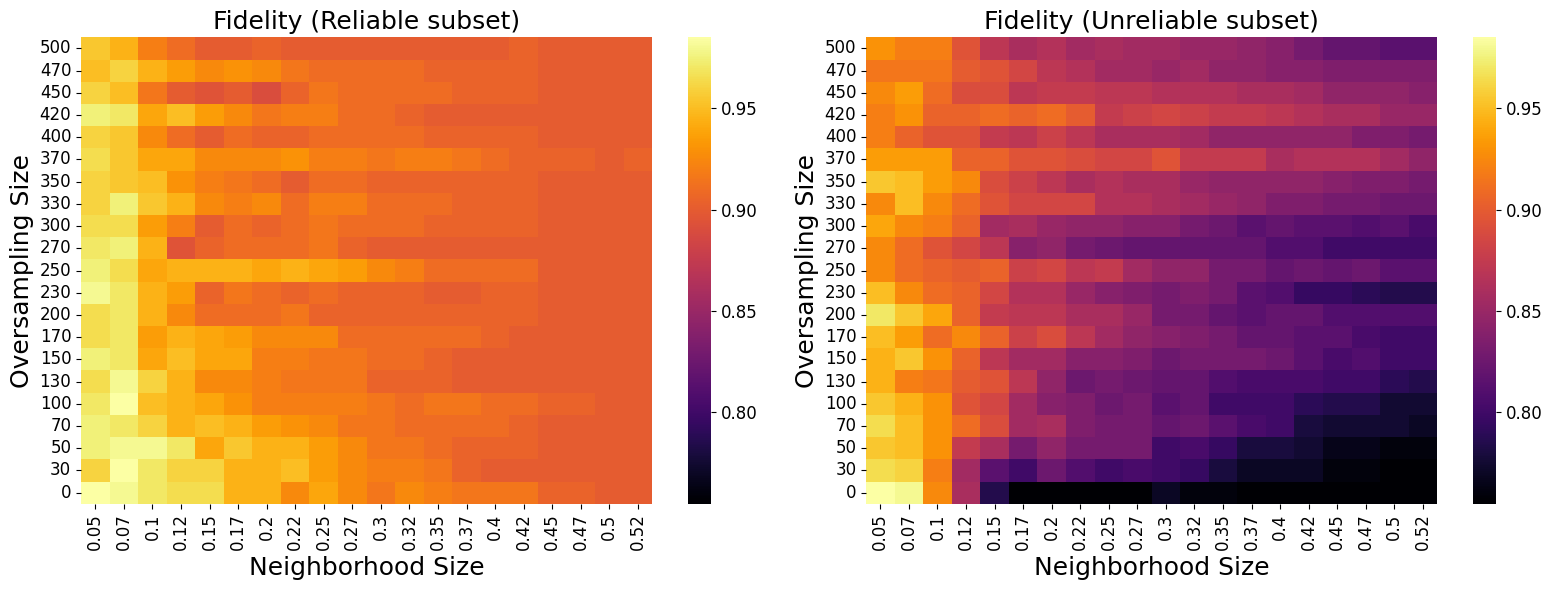

In [32]:
#HeatMap plotting

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap



vmin = min(fidelity_unrel_paramcomb_os+fidelity_rel_paramcomb_os)
vmax = max(fidelity_unrel_paramcomb_os+fidelity_rel_paramcomb_os)


colors = [(1, 0, 0), (0, 0, 1)]
cmap_name = 'custom'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the heatmap on the first subplot
hm1 = sns.heatmap(hm_rel_nos_os[::-1], cmap='inferno', xticklabels=n_size, yticklabels=o_sizes[::-1], ax=axes[0], vmin=vmin, vmax=vmax,)
axes[0].set_xlabel('Neighborhood Size', fontsize=18)
axes[0].set_ylabel('Oversampling Size', fontsize=18)
axes[0].set_title('Fidelity (Reliable subset)', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=12)

cbar1 = hm1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=12)

hm2= sns.heatmap(hm_unrel_nos_os[::-1], cmap='inferno', xticklabels=n_size, yticklabels=o_sizes[::-1], ax=axes[1], vmin=vmin, vmax=vmax, cbar=True)
axes[1].set_xlabel('Neighborhood Size', fontsize=18)
axes[1].set_ylabel('Oversampling Size', fontsize=18)
axes[1].set_title('Fidelity (Unreliable subset)', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)

cbar2 = hm2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


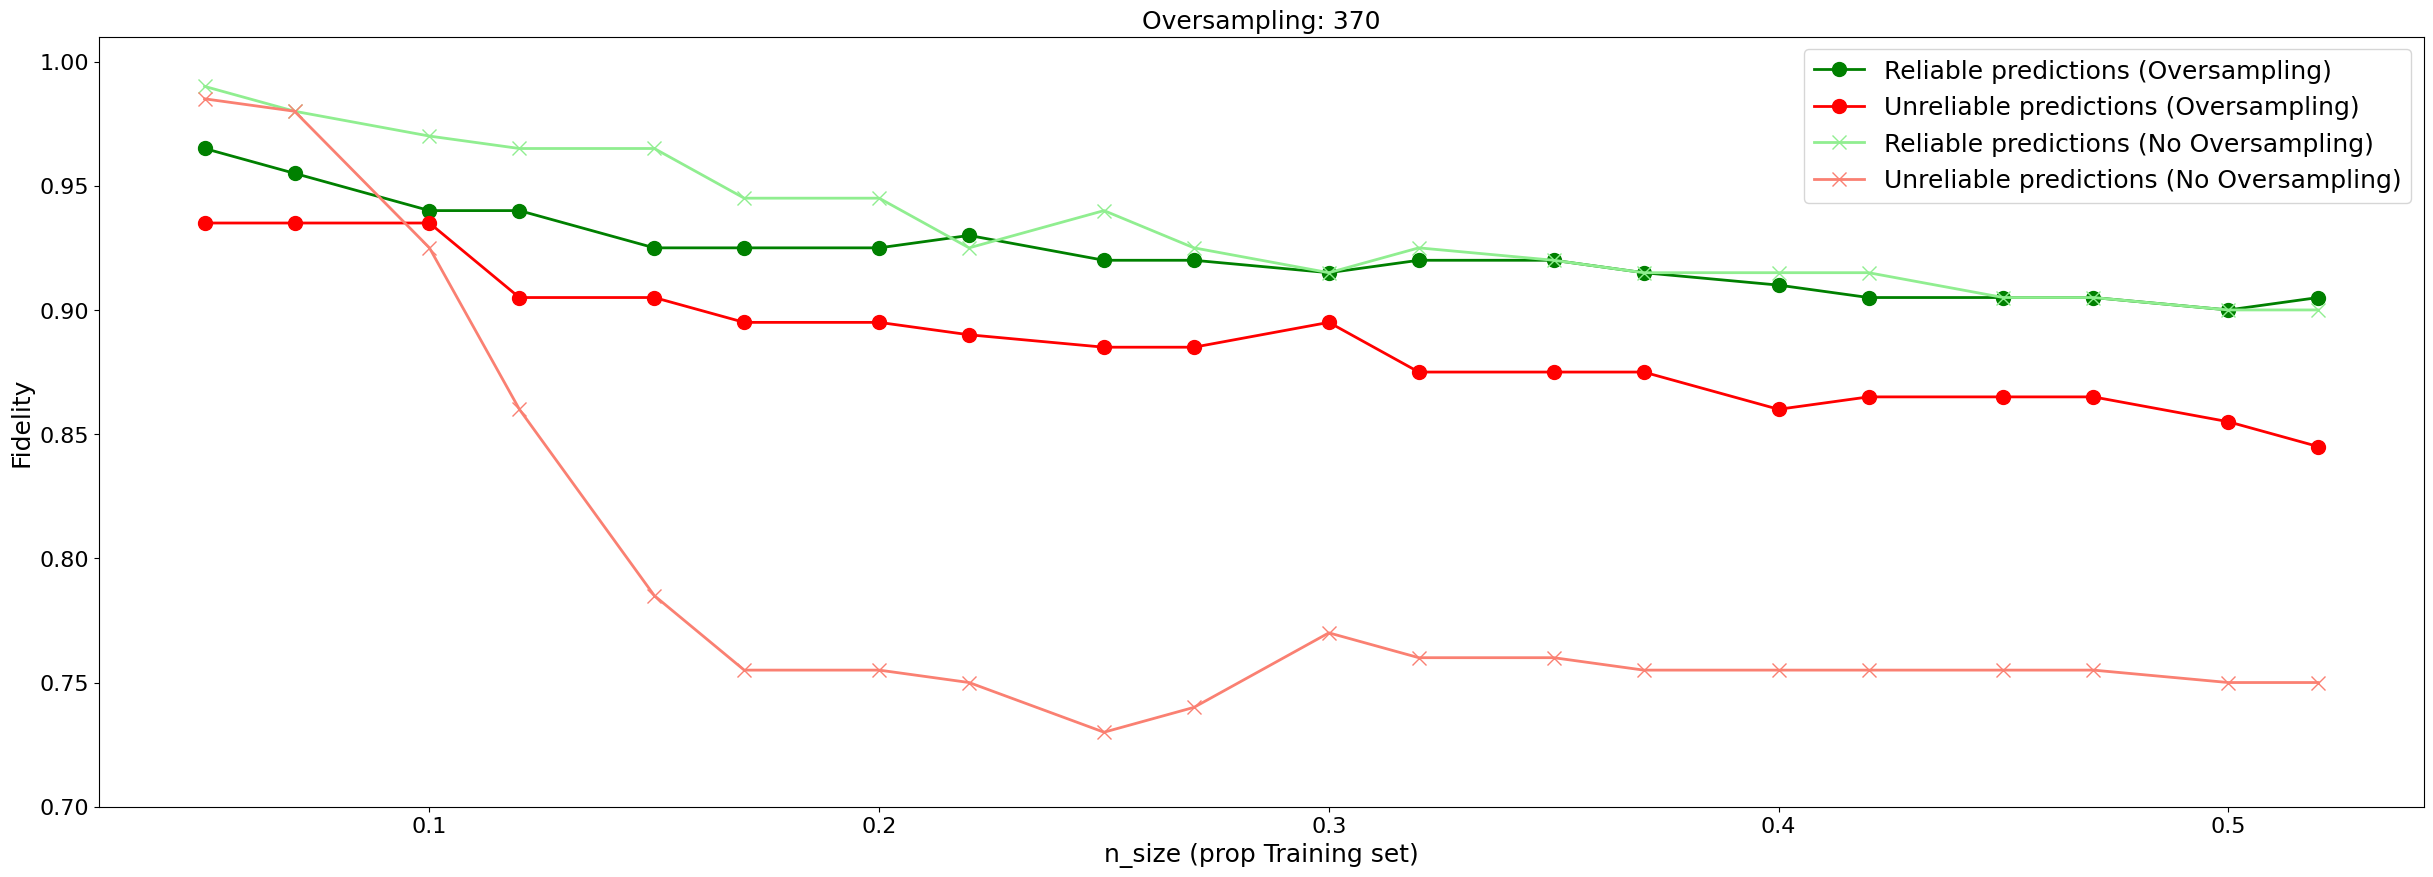

In [40]:
#negative os_ix negativo -> plot the non-oversampling case.
# os_ix possible values :
# {-1: 0, 0: 30, 1: 50, 2: 70, 3: 100, 4: 130, 5: 150, 6: 170, 7: 200, 8: 230, 9: 250, 10: 270, 11: 300, 12: 330, 13: 350, 14: 370, 15: 400, 16: 420, 17: 450, 18: 470, 19: 500}
os_ix = 14


fig, ax = plt.subplots(nrows = len(depth_max), ncols = 1, figsize=(30,10))
rel_dep_i_nos = []
unrel_dep_i_nos = []
rel_dep_i_os = []
unrel_dep_i_os = []

for i in range(len(depth_max)):
  rel_dep_i_nos.append(fidelity_rel_paramcomb_nos[i*len(n_size)*len(o_size):(i+1)*len(n_size)*len(o_size):len(o_size)])
  unrel_dep_i_nos.append(fidelity_unrel_paramcomb_nos[i*len(n_size)*len(o_size):(i+1)*len(n_size)*len(o_size):len(o_size)])
  if os_ix >= 0:
    rel_dep_i_os.append(fidelity_rel_paramcomb_os[i*len(n_size)*len(o_size)+os_ix:(i+1)*len(n_size)*len(o_size):len(o_size)])
    unrel_dep_i_os.append(fidelity_unrel_paramcomb_os[i*len(n_size)*len(o_size)+os_ix:(i+1)*len(n_size)*len(o_size):len(o_size)])
    ax.plot(n_size, rel_dep_i_os[i], color = 'green', marker = 'o', label = 'Reliable predictions (Oversampling)', linewidth = 2, markersize=10)
    ax.plot(n_size, unrel_dep_i_os[i], color = 'red', marker = 'o', label = 'Unreliable predictions (Oversampling)', linewidth = 2, markersize=10)

  ax.plot(n_size, rel_dep_i_nos[i], color = 'lightgreen', marker = 'x', label = 'Reliable predictions (No Oversampling)', linewidth = 2, markersize=10)
  ax.plot(n_size, unrel_dep_i_nos[i], color = 'salmon', marker = 'x', label = 'Unreliable predictions (No Oversampling)', linewidth = 2, markersize=10)


  ax.tick_params(labelsize=16)
  ax.set_ylim(0.70,1.01)
  ax.set_xlabel('n_size (prop Training set)', size = 18)
  ax.set_ylabel('Fidelity', size = 18)
  if os_ix >= 0:
    ax.set_title('Oversampling: '+str(o_size[os_ix]), size = 18)
  else:
    ax.set_title('No Oversampling', size = 18)
  ax.legend(fontsize = 18)

In [34]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap

# # Generate random data for the fidelity
# # Assuming hm_rel_os is your data array
# # Assuming n_size and o_sizes are your labels for x and y axes respectively

# vmin = min(fidelity_unrel_paramcomb_nos+fidelity_rel_paramcomb_nos)
# vmax = max(fidelity_unrel_paramcomb_nos+fidelity_rel_paramcomb_nos)

# colors = [(1, 0, 0), (0, 0, 1)]
# cmap_name = 'custom'
# custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# # Create a figure and two subplots
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Plot the heatmap on the first subplot
# sns.heatmap(hm_rel_nos[::-1], cmap='inferno', xticklabels=n_size, yticklabels=o_size[::-1], ax=axes[0], vmin=vmin, vmax=vmax)
# axes[0].set_xlabel('Neighborhood Size')
# axes[0].set_ylabel('Oversampling Size')
# axes[0].set_title('Reliable Fidelity')

# # Plot the second heatmap on the second subplot (assuming you have another data array)
# # Replace 'your_data2' with the actual data array you want to plot
# # Replace 'n_size2' and 'o_sizes2' with the actual labels for the second plot
# # You may need to adjust other parameters accordingly
# sns.heatmap(hm_unrel_nos[::-1], cmap='inferno', xticklabels=n_size, yticklabels=o_size[::-1], ax=axes[1], vmin=vmin, vmax=vmax)
# axes[1].set_xlabel('Neighborhood Size')
# axes[1].set_ylabel('Oversampling Size')
# axes[1].set_title('Unreliable Fidelity')

# plt.tight_layout()  # Adjust layout to prevent overlapping
# plt.show()


In [35]:
#Average and std dev of fidelity of the reliable and unreliable subsets of the OOD set, with and without the selcted oversampling size

rel_avg_nos = []
rel_avg_os = []
unrel_avg_nos = []
unrel_avg_os = []

rel_std_nos = []
rel_std_os = []
unrel_std_nos = []
unrel_std_os = []

for i in range(len(rel_dep_i_nos)):
  rel_avg_nos.append(np.mean(rel_dep_i_nos[i]))
  rel_avg_os.append(np.mean(rel_dep_i_os[i]))
  unrel_avg_nos.append(np.mean(unrel_dep_i_nos[i]))
  unrel_avg_os.append(np.mean(unrel_dep_i_os[i]))

  rel_std_nos.append(np.std(rel_dep_i_nos[i]))
  rel_std_os.append(np.std(rel_dep_i_os[i]))
  unrel_std_nos.append(np.std(unrel_dep_i_nos[i]))
  unrel_std_os.append(np.std(unrel_dep_i_os[i]))

print("RELIABLE")
print("                     NOS                   OS "+str(o_size[os_ix]))
print("                  avg | std              avg | std\n")
for i in range(len(rel_dep_i_nos)):
  print("MD:", depth_max[i], "       ", '{0:.5f}'.format(rel_avg_nos[i]), "|", '{0:.5f}'.format(rel_std_nos[i]), "    ", '{0:.5f}'.format(rel_avg_os[i]), "|", '{0:.5f}'.format(rel_std_os[i]))

print("\n\nUNRELIABLE")
print("                     NOS                   OS "+str(o_size[os_ix]))
print("                  avg | std              avg | std\n")
for i in range(len(unrel_dep_i_nos)):
  print("MD:", depth_max[i], "       ", '{0:.5f}'.format(unrel_avg_nos[i]), "|", '{0:.5f}'.format(unrel_std_nos[i]), "    ", '{0:.5f}'.format(unrel_avg_os[i]), "|", '{0:.5f}'.format(unrel_std_os[i]))

RELIABLE
                     NOS                   OS 450
                  avg | std              avg | std

MD: 2         0.93325 | 0.02703      0.90925 | 0.01653


UNRELIABLE
                     NOS                   OS 450
                  avg | std              avg | std

MD: 2         0.79150 | 0.07711      0.87275 | 0.02532


Compute the needed statistical tests

In [36]:
import scipy.stats as stats

In [37]:
dp_ix = 0
stats.shapiro(rel_dep_i_nos[dp_ix])

ShapiroResult(statistic=0.9039652347564697, pvalue=0.04896743968129158)

In [38]:
dp_ix = 0
stats.levene(unrel_dep_i_nos[dp_ix], unrel_dep_i_os[dp_ix], center = 'mean')

LeveneResult(statistic=10.448943209234507, pvalue=0.002538091273608104)

In [39]:
dp_ix = 0
stats.wilcoxon(unrel_dep_i_os[dp_ix], unrel_dep_i_nos[dp_ix], alternative = 'greater')

WilcoxonResult(statistic=202.0, pvalue=2.384185791015625e-05)